# Exploration 10 : 이미지 생성 모델링

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

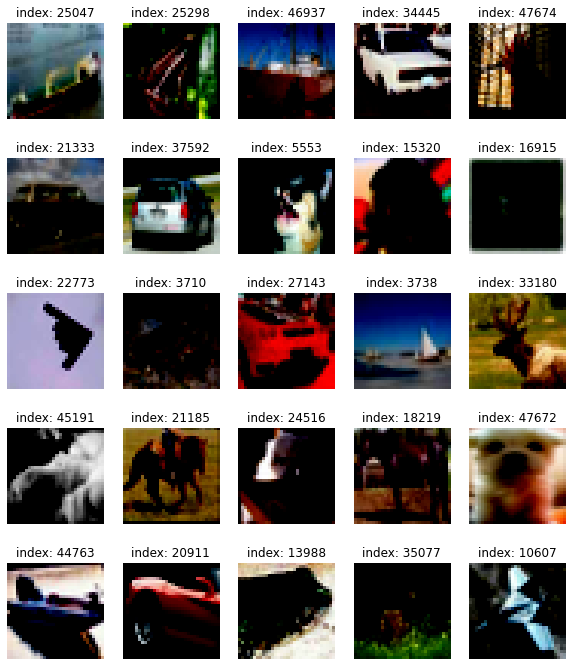

In [4]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [5]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 모델 빌드

In [5]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [6]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [7]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [11]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    np_generated = predictions.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(np_generated.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_generated[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/E10/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/E10/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [21]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/E10/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [23]:
save_every = 5
EPOCHS = 700

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

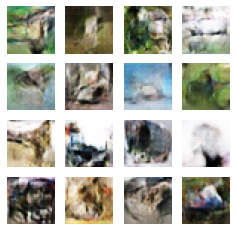

Time for training : 11922 sec


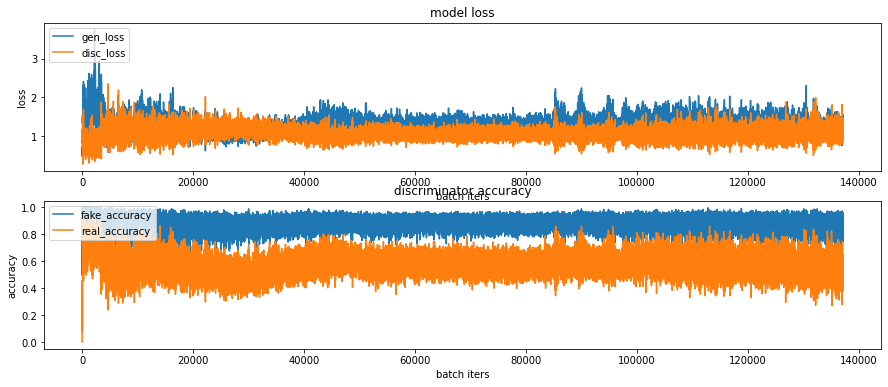

CPU times: user 3h 23min 35s, sys: 19min 19s, total: 3h 42min 55s
Wall time: 3h 18min 50s


In [24]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

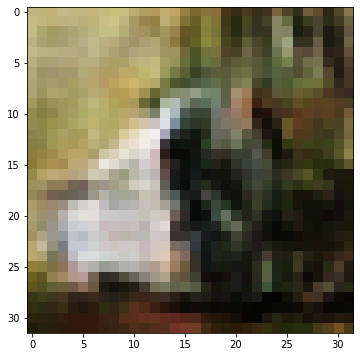

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/E10/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [26]:
anim_file = os.getenv('HOME')+'/aiffel/E10/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/E10/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/E10/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1076071 Feb 10 03:09 /aiffel/aiffel/E10/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


## 모델 개선

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

tensorflow 2.6.0
170508288/170498071 [==============================] - 3s 0us/step
max pixel: 1.0
min pixel: -1.0


In [2]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)

In [3]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [4]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [5]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [6]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    np_generated = predictions.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(np_generated.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_generated[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/E10/dcgan_newimage/cifar10_3/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)
    plt.plot(history['real_accuracy'])
    plt.plot(history['fake_accuracy'])
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy','real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/E10/dcgan_newimage/cifar10_3/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [8]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [10]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [11]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [12]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [13]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/E10/dcgan_newimage/cifar10_3/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
save_every = 5
EPOCHS = 500

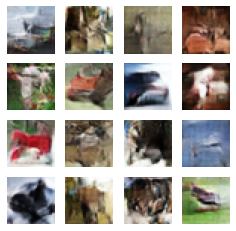

Time for training : 15537 sec


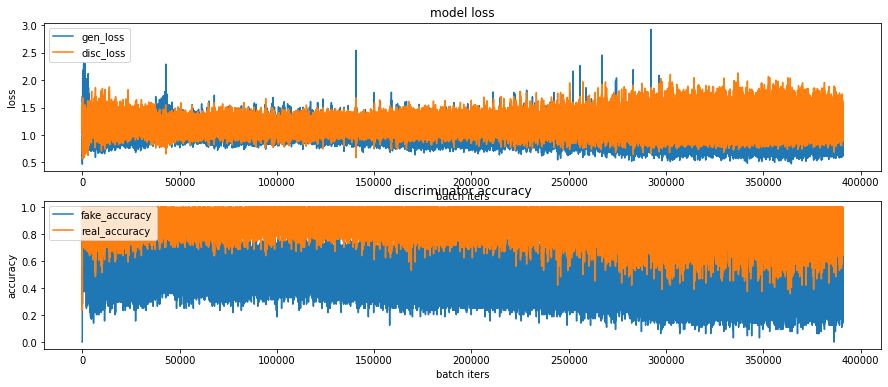

CPU times: user 3h 41min 59s, sys: 32min 55s, total: 4h 14min 54s
Wall time: 4h 19min 18s


In [15]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

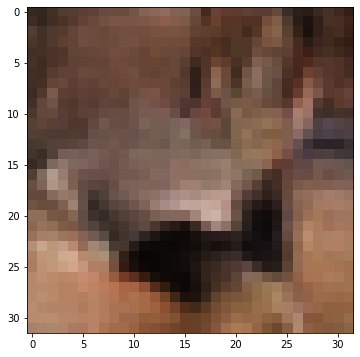

In [16]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/E10/dcgan_newimage/cifar10_3/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [17]:
anim_file = os.getenv('HOME')+'/aiffel/E10/dcgan_newimage/cifar10_3/cifar10_3_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/E10/dcgan_newimage/cifar10_3/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/E10/dcgan_newimage/cifar10_3/cifar10_3_dcgan.gif

-rw-r--r-- 1 root root 6536385 Feb 15 08:47 /aiffel/aiffel/E10/dcgan_newimage/cifar10_3/cifar10_3_dcgan.gif


## 비교 분석

**회차별로 모두 개별 디렉터리를 생성하고 자료화하고 싶었지만 매번 코드도 바꿔야되고 여러모로 귀찮아서 안일하게 생각하고 진행했다가 몇가지 문제에 부딪혔다.**

>* .gif파일만으로 결과를 보려고 했지만 너무 번쩍거리고 빨라서 눈이 아팠다. 결국 결과 샘플들을 별도로 저장했어야 했는데 계속 덮어써지고 있었기 때문에 대부분 건지지 못했다. 그와 더불어 달라지는 epoch에 따라 전 회차의 남은 샘플들이 .gif에 덧씌워져서 .gif파일까지 이상해졌다.
>* 개선 방식에 활용된 개념들(학습률, 레이블 스무딩, 배치사이즈)에 대한 충분한 이해가 없었기 때문에 달라지는 결과를 보고 올바른 판단을 할 수 가 없었다. 많이 찾아보면서 아주 편협하게 조금은 알게 되었을지도.
>* 그래프상에서는 확실한 개선이 있었고 목표에 도달할 최상의 파라미터까지 예측할 수 있었지만 생성된 이미지에 대해서는 전혀 만족스러운 결과가 없었다. cifar10의 실제 이미지도 그다지 선명한 편은 아니였지만 9회차 중 16장을 모두 구별가능한 결과는 한 건도 없었다.

### 일단 한번 보자
#### 1회차

![](./train_history_1st_result.png)
![](./cifar10_1st.gif)

#### 2회차

![](./train_history_2nd_result_stop.png)
![](./cifar10_2nd.gif)

#### 3회차

![](./train_history_3rd_result.png)
![](./cifar10_3rd.gif)

#### 4회차

![](./train_history_4th.png)
![](./cifar10_4th.gif)

#### 5회차

![](./train_history_5th.png)
![](./cifar10_5th.gif)

#### 6회차

![](./train_history_6th.png)
![](./cifar10_6th.gif)

#### 7회차

![](./train_history_7th.png)
![](./cifar10_7th.gif)

#### 8회차

![](./train_history_8th.png)
![](./sample_8th.png)

#### 9회차

![](./train_history_9th.png)
**sample 결과 : 위에서부터 epoch 320, 350, 380, 400, 420, 450, 470**
![](./sample_9th_epoch_0320_iter_751.png)
![](./sample_9th_epoch_0350_iter_751.png)
![](./sample_9th_epoch_0380_iter_751.png)
![](./sample_9th_epoch_0400_iter_751.png)
![](./sample_9th_epoch_0420_iter_751.png)
![](./sample_9th_epoch_0450_iter_751.png)
![](./sample_9th_epoch_0470_iter_751.png)

#### 각 회차에 사용된 파라미터
1st<br>
batch_size=256, learning_rate=0.0001, epochs=700<br><br>
2st stopped<br>
batch_size=256, learing_rate=0.001, label_smoothing=0.05, epochs=700<br><br>
3st<br>
batch_size=400, learnign_rate=0.0006, epochs=800<br><br>
4st<br>
batch_size=256, learing_rate=0.0006, label_smoothing=0.01, epochs=800<br><br>
5st<br>
batch_size=64, learing_rate=0.00006, label_smoothing=0.1, epochs=300<br><br>
6th bb<br>
batch_size=64, learning_rate=0.00004 label_smoothing=0.2, epochs=400<br><br>
7th<br>
batch_size=128, learning_rate=0.0002, epochs=200<br><br>
8th stopped<br>
batch_size=64, learning_rate=0.0002, label_smoothing=0.1, epochs=400<br><br>
9th<br>
batch_size=64, learning_rate=0.0001, label_smoothing=0.1, epochs=500<br><br>

### 개선실험 진행에 대한 고찰과 결론

최초에는 무작위로 파라미터를 변경하거나 추가하고자 했고 전혀 원하던 결과와 가까워지지 않는 것 같아 추가 조사를 꽤 많이 한 것 같다. 많은 자료가 있었지만 모델 계층 구성에 대한 변경, 활성함수 선택, optimizer 선택 등은 내 수준에서 만지기 힘들 것이라고 판단해서(잘못되었을 때 돌이킬 자신이 없었음) 코드 상 아주 간편하게 변경할 수 있을 만한 부분으로 learning_rate, label_smoothing, batch_size, epoch 정도만 조절하면서 진행했다. 우선 자료와 실험을 통해 알게된 사실은 다음과 같다.

1. 아예 다른 종류의 레이어를 사용했거나 아예 다른 모델을 사용한 경우도 있는 것 같다. 정확히 알거나 이해하지 못했기 때문에 넘어갔다.
2. 활성함수를 LeakyRelu 가 아닌 일반 Relu, 혹은 다른 것을 사용한 경우도 있는 듯 하다.
3. DCGAN에서 batch_size는 작을 때 성능이 좋더라 하는 포스팅이 있었다.
4. batch_size와 learning_rate은 어떤 비례관계에 있는 듯 하다.(작은 배치에는 작은 학습률을, 큰 배치에서는 어느정도 큰 학습률을 적용해야 한다고 한다.)
5. 0.00001의 학습률은 굉장히 낮은 편에 속하는 것 같다.(배치기준 64-128에서 대부분 0.0001-0.0002를 사용하더랬다.)
6. 배치 256은 매우 큰 수치이다.(cifar10 문제해결 코드 기준 대부분 64-128 사이를 사용한 듯 하다.)
7. learning_rate를 낮추는 것은 accuracy 그래프 관점에서 진폭을 낮추는데 도움이 된다.
8. 최소한 내가 실험한 영역 안에서는 레이블 스무딩을 사용하지 않은 것이 생성된 이미지 기준에서는 제일 나은 것 같다.
9. D와 G의 업데이트 횟수와 간격을 조절하는 것도 학습에 영향을 미친다고 한다.

**상기 사용된 모델을 기준으로 내가 생각한 최상의 파라미터**  (제출기한이 빠듯한 관계로 돌려보진 못함)

batch_size 64<br>
learning_rate 0.0001 - 0.0002<br>
label_smoothing X<br>
epoch 250 - 350

###### p.s. 쓸데없이 많이 나열되어 있어서 가독성이 떨어져 채점하시는 퍼실님을 힘들게 하는 점 심심한 사과의 말씀을 드립니다.

# 회고

## 좋은 건지 나쁜 건지...

학습에 엄청나게 오랜 시간이 걸리고(평균 3-4시간?) 학습하는 동안 LMS가 멈추기 때문에 아무것도 할 수가 없다... 학습 돌려놓고 책이나 보면서 뭔가 오히려 좋은 것 같기도 하고..? 다만 부족한 이해를 몸으로 때우려는 나같은 타입의 학생은 너무 힘들었다. 밤에 학습 돌려놓고 자려다가 궁금해서 자꾸 중간에 보면서 잠 설치고, 야간에 일이 있을 때는 아예 밤을 새야했다. 덕분에 이틀 연속 지각에 성공! ㅎㅎ

## 정리를 잘 하자

모델이 점점 무거워지고 다루는 주제도 무거워지는 만큼 데이터도 코드도 무거워진다. 여러가지로 실험을 하면서 기존 코드를 훼손하지 않으면서도 내가 어떤 방식으로 진행했는지를 알 수 있게 코드를 구별하고 생성된 데이터들을 잘 정리하는 것도 하나의 능력인 듯 하다. 코드를 매번 구별하는 것과 데이터가 덮어씌워지거나 하지 않도록 매번 빼놓고 저장하는 절차들이 너무 귀찮았다. 코드 자체를 구별이 쉽게 혹은 변경 자체가 용이하도록 만들고 저장 자체를 매번 알아서 착착 하도록 만들 수도 있는 것으로 알고 있지만 나의 능력 부족이다. 코딩공부를 겁나 열심히 해야겠다..

## Ref.

* gan - batch_size, learning_rate<br>
https://ndb796.tistory.com/689<br><br>

* label smoothing<br>
https://sincerechloe.tistory.com/70<br>
https://blog.si-analytics.ai/21<br><br>

* instance normalization<br>
https://www.tensorflow.org/addons/tutorials/layers_normalizations?hl=ko<br><br>

* dcgan_codes<br>
https://wandb.ai/sairam6087/dcgan/reports/DCGAN-on-CIFAR-10--Vmlldzo5NjMyOQ<br>
https://medium.com/@stepanulyanin/dcgan-adventures-with-cifar10-905fb0a24d21<br>
https://www.kaggle.com/laszlofazekas/cifar10-dcgan-example<br>
